In [ ]:
!pip install category_encoders
!pip3 install hyperopt
!pip3 install pdpbox
!pip3 install xgboost==1.7.2
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_plot, pdp_isolate
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
# 파일 업로드
from google.colab import files
files.upload()
data = pd.read_csv('final_data_2.csv')

Saving final_data_2.csv to final_data_2.csv


In [ ]:
df = data.copy()

In [ ]:
# 데이터셋 분리
target = 'full_power'
features = df.drop(target, axis=1).columns

X = df[features]
y = df[target]

# train/val/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

# 확인
print('train set:', X_train.shape, y_train.shape)
print('val set:', X_val.shape, y_val.shape)
print('test set:', X_test.shape, y_test.shape)

train set: (4361, 12) (4361,)
val set: (1091, 12) (1091,)
test set: (1364, 12) (1364,)


In [ ]:
# one-hot encoding
encoder = OneHotEncoder()
X_train_ohe = encoder.fit_transform(X_train)
X_val_ohe = encoder.transform(X_val)
X_test_ohe = encoder.transform(X_test)

In [ ]:
# XGB 모델 생성
model = XGBRegressor(
    eval_metric="mae",
    n_estimators = 9999999,
    random_state = 42,
)

# 파라미터 범위
params = {
    'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': range(2,20,2),
    'min_child_weight': range(2,20,2),
    'subsample' : [0.2, 0.4, 0.6, 0.8],
    'colsample_bytree' : [0.2, 0.4, 0.6, 0.8],
}

# Randomized Search
random_search_xgb = RandomizedSearchCV(
    model,
    param_distributions=params,
    random_state = 42,
    scoring = "neg_mean_absolute_error",
    n_iter = 50,
    cv=3,
    verbose = False,
)

watchlist = [(X_train_ohe, y_train), (X_val_ohe, y_val)]

# 학습
random_search_xgb.fit(X_train_ohe, y_train,
                      eval_set=watchlist,
                      early_stopping_rounds=100,
                      verbose=False,
)
print('최고 파라미터 : ', random_search_xgb.best_params_)
print('')
print('최적 mae : ', -(random_search_xgb.best_score_))


최고 파라미터 :  {'subsample': 0.8, 'min_child_weight': 16, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.4}

최적 mae :  4265.5003301152165


In [ ]:
# 최적의 하이퍼파라미터로 모델 생성(1)
model = XGBRegressor(
    eval_metric="mae",
    n_estimators = 9999999,
    random_state = 42,
    min_child_weight = 16,
    subsample = 0.8,
    colsample_bytree = 0.4,
)

# 파라미터 범위
params = {
    'learning_rate' : [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 7],
}

# Grid Search
grid_search_xgb = GridSearchCV(
    model,
    param_grid = params,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    verbose = False,
)


watchlist = [(X_train_ohe, y_train), (X_val_ohe, y_val)]

# 학습
grid_search_xgb.fit(X_train_ohe, y_train,
                      eval_set = watchlist,
                      early_stopping_rounds = 100,
                      verbose=False,
)
print('최적 파라미터 : ', grid_search_xgb.best_params_)
print('')
print('최적 mae : ', -(grid_search_xgb.best_score_))

최적 파라미터 :  {'learning_rate': 0.07, 'max_depth': 5}

최적 mae :  4242.47990471401


In [ ]:
# 최적의 하이퍼파라미터로 최종 모델 생성
model = XGBRegressor(
    eval_metric="mae",
    n_estimators = 9999999,
    random_state = 42,
    min_child_weight = 16,
    subsample = 0.8,
    colsample_bytree = 0.4,
    learning_rate = 0.07,
    max_depth = 5,
)

watchlist = [(X_train_ohe, y_train), (X_val_ohe, y_val)]

# 학습
model.fit(X_train_ohe, y_train,
          eval_set = watchlist,
          early_stopping_rounds = 100,
          verbose=False,
)

# r2, mae
pred_test = model.predict(X_test_ohe)
test_r2 = r2_score(y_test,pred_test)
test_mae = mean_absolute_error(y_test,pred_test)


# r2, mae 확인
print('test r2 score : ', test_r2)
print('test MAE score : ', test_mae)

test r2 score :  0.7898032738940193
test MAE score :  4226.434220926503


In [ ]:
# 데이터프레임으로 점수 확인
final_model_score = pd.DataFrame(columns = ['Metric','Score'])
final_model_score['Metric'] =['r2','mae']
final_model_score['Score'] =[ test_r2, test_mae]
final_model_score 

,Metric,Score
0,r2,0.789803
1,mae,4226.434221


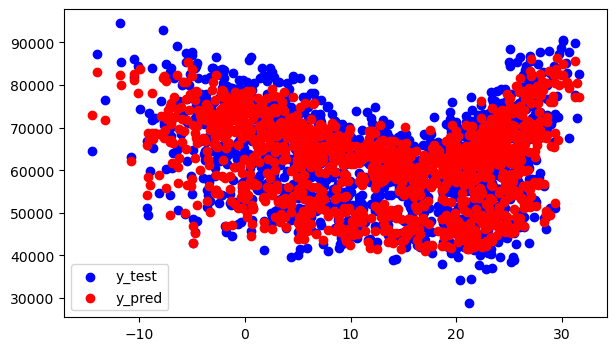

In [ ]:
# 예측값과 실제값 분포
plt.figure(figsize=(7,4))
plt.scatter(X_test_ohe['average_temperature'],y_test,label='y_test',c='b')
plt.scatter(X_test_ohe['average_temperature'],pred_test,label='y_pred',c='r')
plt.legend()
plt.show()

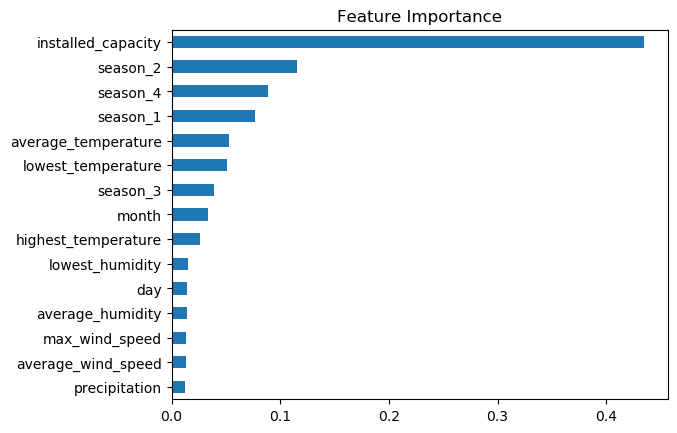

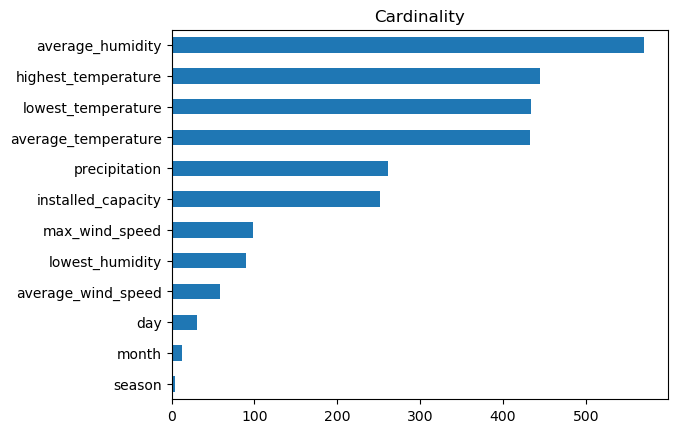

In [ ]:
# MDI
importances = pd.Series(model.feature_importances_, X_train_ohe.columns)

importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

X_train.nunique().sort_values().plot.barh()
plt.title("Cardinality")
plt.show()

In [ ]:
encoder.category_mapping

[{'col': 'season',
  'mapping': Spring    1
  Winter    2
  Summer    3
  Autumn    4
  NaN      -2
  dtype: int64,
  'data_type': dtype('O')}]

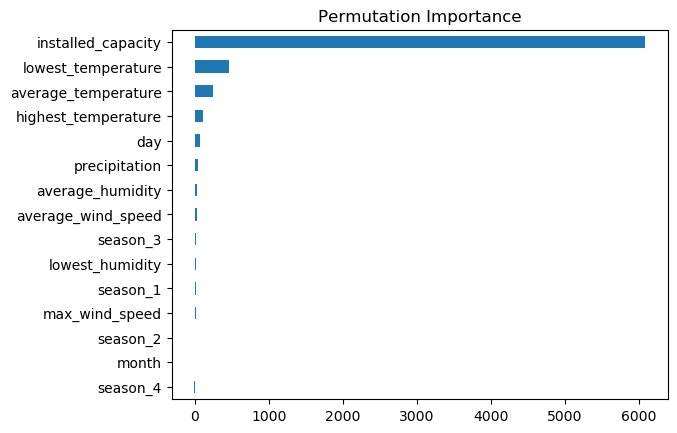

In [ ]:
# Permutation Importance
permuter = PermutationImportance(
    model, 
    scoring="neg_mean_absolute_error",  
    n_iter=10, 
    random_state=2,
)

# 스코어를 다시 계산합니다.
permuter.fit(X_test_ohe, y_test)

feature_names = X_test_ohe.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")
plt.show()

In [ ]:
# 특성별 score을 확인합니다.
eli5.show_weights(
    permuter,
    top=None,  
    feature_names=feature_names,
)

Weight,Feature
6087.0089 ± 247.8758,installed_capacity
460.0634 ± 91.7590,lowest_temperature
247.0335 ± 64.5520,average_temperature
105.4920 ± 46.8354,highest_temperature
71.0929 ± 36.5705,day
47.2449 ± 11.7233,precipitation
32.9300 ± 20.9821,average_humidity
24.3919 ± 25.7136,average_wind_speed
13.5475 ± 7.3415,season_3
12.5937 ± 29.4027,lowest_humidity


In [ ]:
df['average_temperature'].mean()

13.008802816901408

(<Figure size 1500x950 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d7f937850>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4d7d101b80>})

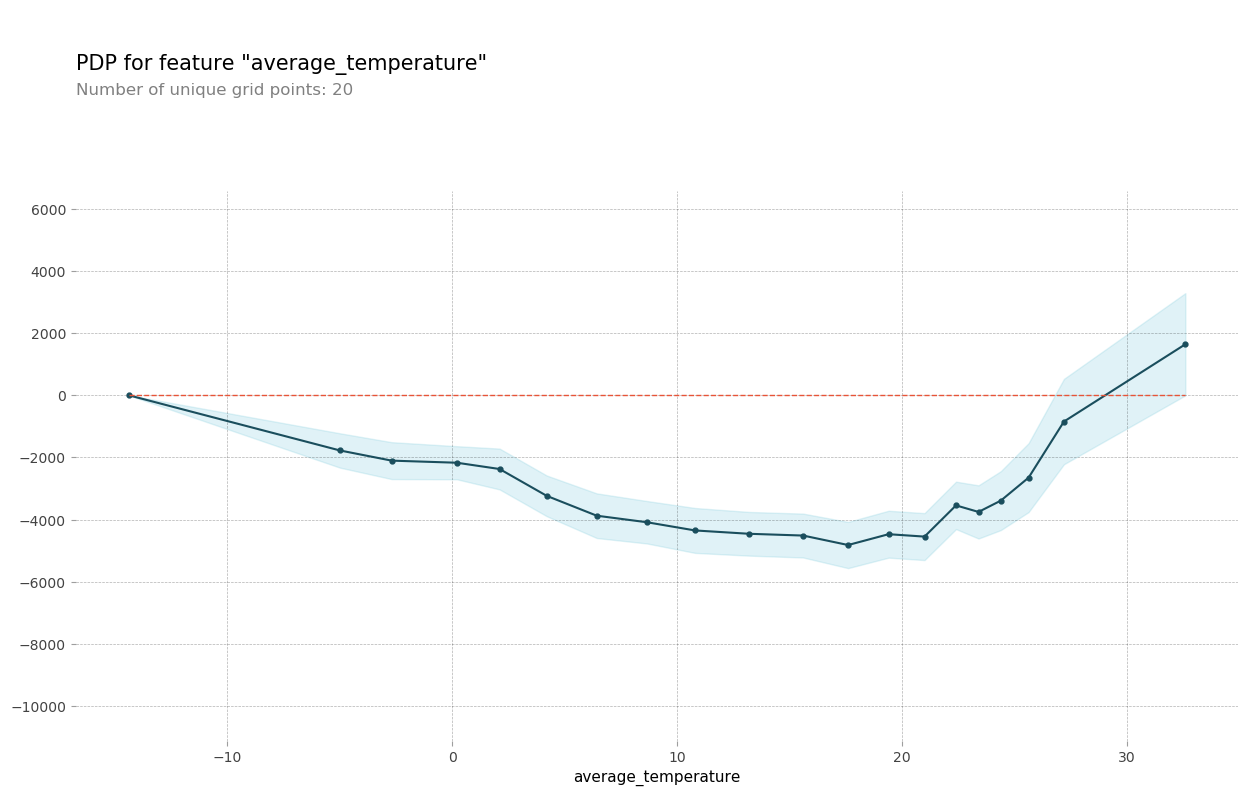

In [ ]:
target_feature = "average_temperature"

isolated = pdp_isolate(
    model=model,
    dataset=X_val_ohe,
    model_features=X_val_ohe.columns,
    feature=target_feature,
    grid_type="percentile", 
    num_grid_points=20, 
)
pdp_plot(isolated, feature_name=target_feature)